https://github.com/mrokld/workshop_kgd

# Задача object detection и SSD 
<center><img src="./im/car.jpeg" width="400"/></center>

Существует два основных подхода к решению задачи с помощью этих ваших диплёнингов: one stage и two stage.
<br><br>Для первого наиболее известные представители: <br>
Yolo [ https://pjreddie.com/media/files/papers/yolo.pdf , https://pjreddie.com/media/files/papers/YOLOv3.pdf  ], <br> SSD  [ https://arxiv.org/pdf/1512.02325 ], RetinaNet [ https://arxiv.org/abs/1708.02002 ].
<br>
<br> Для второго - Faster-RCNN [ https://arxiv.org/pdf/1506.01497.pdf ]
<br>
<br> Разного рода модификации [ https://paperswithcode.com/sota/object-detection-on-coco ]
<br><br><br><br><br><br><br><br><br><br><br><br>

### Faster-RCNN:
<img src="./im/Faster-RCNN.png" width="600"/>

[ https://towardsdatascience.com/review-faster-r-cnn-object-detection-f5685cb30202 ]

Region proposals and ROI pooling in two-stage detector Faster-RCNN
<br><br><br><br>

<br><br><br><br>
### SSD vs YOLO:

<img src="./im/ssd_vs_yolo.png" width=800/>

[ https://arxiv.org/pdf/1512.02325 ]

В SSD отсутствуют Fully Connected Layers в отличие от YOLO

<br>
<br>
<br>
<br>

### SSD

<img src="./im/ssd_understandable.jpeg" />
[ https://medium.com/@smallfishbigsea/understand-ssd-and-implement-your-own-caa3232cd6ad ]

Структура SSD. Предсказывается 20 классов + background, для каждого слоя генерируется разное количество prior box-ов

<br>
<br>
<br>

# Receptive field

<img src="./im/receptive_field.png" width="550"/>

[ Lin, Haoning & Shi, Zhenwei & Zou, Zhengxia. (2017). Maritime Semantic Labeling of Optical Remote Sensing Images with Multi-Scale Fully Convolutional Network. Remote Sensing. 9. 480. 10.3390/rs9050480.  ]


<center><img src="./im/overlaps.png" /></center>


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Prior Boxes
Мы считаем, что каждый feature map отвечает за свой масштаб объектов. Значит, на нужно посчитать этот самый масштаб:

<img src="./im/scale.png" />

Где $s_{k}$ - масштаб, <br> $s_{min} = 0.2$, $s_{max} = 0.9$ означают, что нижний слой имеет масштаб 0.2, самый верхний - 0.9

In [4]:
# Change m number
m = 6 # number of feature maps
s_min = 0.2
s_max = 0.9

scales = []

for k in range(1, m+1):
    s_k = s_min + ((s_max - s_min)/(m - 1)) * (k - 1)
    scales.append(s_k)
    print('For {} feature map scale will be {}'.format(k, s_k))

For 1 feature map scale will be 0.2
For 2 feature map scale will be 0.33999999999999997
For 3 feature map scale will be 0.48
For 4 feature map scale will be 0.6199999999999999
For 5 feature map scale will be 0.76
For 6 feature map scale will be 0.8999999999999999


<br>
<br>
<br>
Но только масштабов недостаточно. Нам нужно сгенерировать сами prior boxes с координатами  ($cx, cy, w, h$)
<br>
Для этого в статье используют следующие aspect ratio : 

## <center>$ a_{r} \in \{1, 2, 3, {1\over{2}}, {1\over{3}} \} $</center>

после чего, имея масштаб и *aspect ratio* можно посчитать длину и шириу

## <center> $w^{a}_{k} = s_{k}\sqrt{a_{r}}$ </center>
## <center> $h^{a}_{k} = {s_{k}\over{\sqrt{a_{r}}}}$ </center>

плюс, для *aspect ratio* 1 добавим один default box со следующим масштабом $s^\prime_{k}$ :

## <center> $ s^\prime_{k} = \sqrt{s_{k}s_{k+1}} $ </center>

нам осталось только найти центры $cx, cy$ 

## <center> $ (c_{x}, c_{y}) = ({{i + 0.5}\over{|f_{k}|}}, {{j + 0.5}\over{|f_{k}|}}) $ </center>
, где $|f_{k}|$ - размер *k*-го фичермапа, $ {i,j} \in {[ 0, |f_{k}| )} $

In [6]:
import itertools
from math import sqrt
import numpy as np

aspect_ratios = [1, 2, 1/2, 3, 1/3]
featuremap_sizes = [38, 19, 10, 5, 3, 1]

# calculate

prior_boxes = []

for k, featuremap_size in enumerate(featuremap_sizes):
    
    s_k = scales[k]
    print('For featuremap size {} scale is {}'.format(featuremap_size, s_k))
    
    # calculate one more sacle for bbox with aspect ration = 1 
    if k < len(scales) - 1:
        tmp_s_k = sqrt(s_k * scales[k+1])
    else:
        tmp_s_k = sqrt(s_k * 1.0)
    
    # We wil generate bboxes with 3 and 1/3 aspect ratios for 2-nd, 3-rd and 4-th featuremaps
    if k in [1,2,3]:
        num_ratios = len(aspect_ratios)
    else:
        num_ratios = len(aspect_ratios[:-2])
    
    for i, j in itertools.product(range(featuremap_size), repeat=2):
        cx = (i + 0.5) / featuremap_size
        cy = (j + 0.5) / featuremap_size
        
        for a_r in aspect_ratios[:num_ratios]:
            w = s_k * sqrt(a_r)
            h = s_k / sqrt(a_r)
            prior_boxes.append([cx, cy, w, h])
        
        # Another bbox for aspect ratio == 1
        w = tmp_s_k * sqrt(1)
        h = tmp_s_k * sqrt(1)
        prior_boxes.append([cx, cy, w, h])

# Prevent boxes to be wider or higher than 1.0
prior_boxes = np.clip(np.array(prior_boxes), 0.0, 1.0)

For featuremap size 38 scale is 0.2
For featuremap size 19 scale is 0.33999999999999997
For featuremap size 10 scale is 0.48
For featuremap size 5 scale is 0.6199999999999999
For featuremap size 3 scale is 0.76
For featuremap size 1 scale is 0.8999999999999999


In [7]:
# 8732 prior boxes in original paper
print(' Num prior boxes: {}'.format(len(prior_boxes)))

 Num prior boxes: 8732


In [8]:
prior_boxes[-5:]

array([[0.83333333, 0.83333333, 0.82704293, 0.82704293],
       [0.5       , 0.5       , 0.9       , 0.9       ],
       [0.5       , 0.5       , 1.        , 0.6363961 ],
       [0.5       , 0.5       , 0.6363961 , 1.        ],
       [0.5       , 0.5       , 0.9486833 , 0.9486833 ]])

In [17]:
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

def draw_boxes(img, boxes, linewidth=3):
    
    fig,ax = plt.subplots(1, figsize=(20, 10))
    ax.imshow(img)
    _boxes = boxes*300
    for box in _boxes:
        cx, cy, w, h = box
        x = cx - w/2
        y = cy - h/2
        rect = patches.Rectangle((x,y),w,h,linewidth=linewidth,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    plt.show()

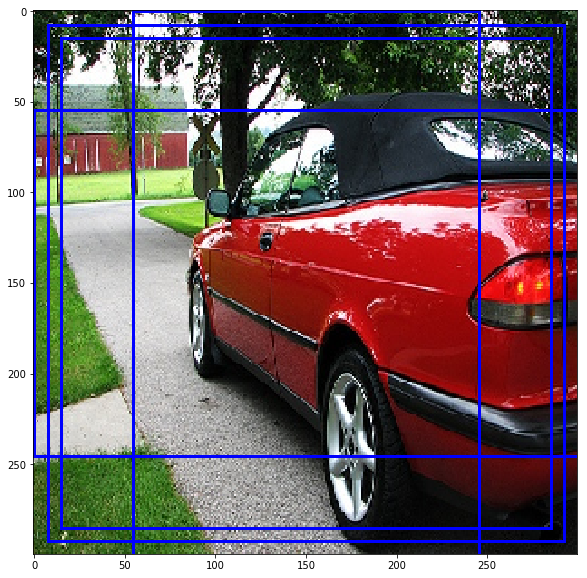

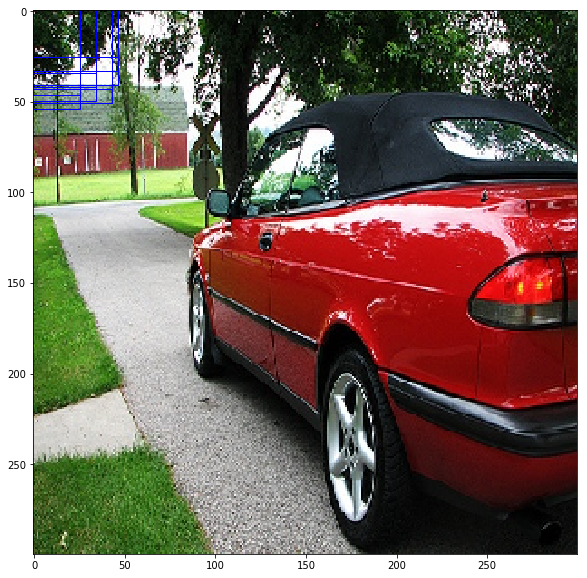

In [18]:
img = np.array(Image.open('./VOC2007/JPEGImages/000007.jpg').resize((300,300)))
draw_boxes(img, prior_boxes[-4:])
draw_boxes(img, prior_boxes[:10], linewidth=1)

<br>
<br>
<br>
<br>

# Matching boxes priors and ground truth

<center><img src="./im/overlaps.png" /></center>


### Оставим только те prior boxes, которые хорошо пересекаются с ground truth. 

<br>
<br>
<br>
<br>

# Intersection over union or jacard similarity

<center><img src="./im/iou.png" /></center>

In [97]:
# Naive IoU implementation
# Boxes format: xmin, ymin, xmax, ymax !!!

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    # return the intersection over union value
    return iou

bb_intersection_over_union([0,0,100,100], [50,50,100,100])

0.2549750024507401

# Loss function

<center><img src="./im/loss_1.png" /></center>


#### $N$ - число отобранных с помощью IoU prior boxes

<br>
<br>
<br>

# $L_{loc}$

<center><img src="./im/loss_2.png" /></center>
<center><img src="./im/l1_loss.png" /></center>

#### $l$ - predicted box, $g$ - ground truth box, $d$ - default (prior) bounding box
#### $x^{p}_{i,j} = \{0,1\}$ - индикатор, равен 1 если i-ый prior box совпадает с j-ым ground truth box категории p


<br>
<br>
<br>

# $L_{conf}$

<center><img src="./im/loss_3.png" /></center>

<br>
<br>
<br>
<br>
<br>
<br>

# Inference and Non Maximum Suppresion

<center><img src="./im/nms.png" /></center>
[https://www.jeremyjordan.me/object-detection-one-stage/]